In [48]:
import os
import pandas as pd

DATA_PATH = os.path.join(os.path.pardir, "dataset", "chap02", "car_evaluation.csv")


def get_data(data_path=DATA_PATH):
    return pd.read_csv(data_path)


get_data()


,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


<AxesSubplot:ylabel='output'>

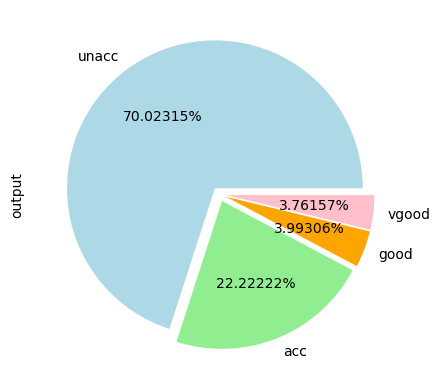

In [49]:
import matplotlib.pyplot as plt

get_data()["output"].value_counts().plot(
    kind="pie",
    autopct="%0.05f%%",
    colors=["lightblue", "lightgreen", "orange", "pink"],
    explode=(0.05, 0.05, 0.05, 0.05),
)


In [50]:
import numpy as np
import torch


def get_categorical_data(
    data=get_data(), categorical_columns=list(get_data().columns[:-1])
):
    categorical_data = (
        data[category].astype("category") for category in categorical_columns
    )
    categorical_data = (
        col_dataset.cat.codes.values for col_dataset in categorical_data
    )
    return torch.tensor(np.stack(list(categorical_data), 1), dtype=int)


print(get_categorical_data().shape)
print(get_categorical_data().dtype)
get_categorical_data()


torch.Size([1728, 6])
torch.int64


tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        ...,
        [1, 1, 3, 2, 0, 1],
        [1, 1, 3, 2, 0, 2],
        [1, 1, 3, 2, 0, 0]])

In [51]:
def get_categorical_output(output=get_data()["output"]):
    outputs = pd.get_dummies(output)
    outputs = outputs.values.argmax(axis=1)
    return torch.tensor(outputs, dtype=int)


print(get_categorical_output().shape)
print(get_categorical_output().dtype)
get_categorical_output()


torch.Size([1728])
torch.int64


tensor([2, 2, 2,  ..., 2, 1, 3])

In [52]:
def split_train_val_test(data: pd.DataFrame, val=0.2, test=0.2):
    train_data = pd.DataFrame()
    val_data = pd.DataFrame()
    test_data = pd.DataFrame()
    for value in data["output"].value_counts().index:
        sub_data = data[data["output"] == value]
        sub_data = sub_data.sample(frac=1, ignore_index=True)
        data_len = len(sub_data)
        val_len = int(data_len * val)
        test_len = int(data_len * test)
        train_len = data_len - val_len - test_len
        train_data = pd.concat(
            [train_data, sub_data[:train_len]], axis=0
        )
        val_data = pd.concat(
            [val_data, sub_data[train_len: train_len + val_len]], axis=0
        )
        test_data = pd.concat(
            [test_data, sub_data[train_len + val_len:]], axis=0
        )
    train_data.sample(frac=1, ignore_index=True)
    val_data.sample(frac=1, ignore_index=True)
    test_data.sample(frac=1, ignore_index=True)
    return (train_data, val_data, test_data)


train_data, val_data, test_data = split_train_val_test(get_data())
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1040, 7)
(344, 7)
(344, 7)


In [53]:
train_output = get_categorical_output(train_data["output"])
val_output = get_categorical_output(val_data["output"])
test_output = get_categorical_output(test_data["output"])
print(train_output.shape)
print(val_output.shape)
print(test_output.shape)
pd.DataFrame(train_output).value_counts()

torch.Size([1040])
torch.Size([344])
torch.Size([344])


2    726
0    232
1     43
3     39
dtype: int64

In [54]:
train_data = get_categorical_data(train_data)
val_data = get_categorical_data(val_data)
test_data = get_categorical_data(test_data)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

torch.Size([1040, 6])
torch.Size([344, 6])
torch.Size([344, 6])


In [55]:
def get_embedding_size(
    data=get_data(), categorical_columns=list(get_data().columns[:-1])
):
    categorical_dataset = [
        data[category].astype("category") for category in categorical_columns
    ]
    categorical_column_sizes = [
        len(categorical_data.cat.categories) for categorical_data in categorical_dataset
    ]
    return [
        (col_size, min(50, (col_size + 1) // 2))
        for col_size in categorical_column_sizes
    ]


get_embedding_size()


[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]

In [56]:
from torch import nn


class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, dropout=0.5) -> None:
        super().__init__()

        all_layers = []
        for hidden_size in hidden_layers:
            all_layers.append(nn.Linear(input_size, hidden_size))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(hidden_size))
            all_layers.append(nn.Dropout(dropout))
            input_size = hidden_size
        all_layers.append(nn.Linear(hidden_layers[-1], output_size))
        all_layers.append(nn.Softmax(-1))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x):
        x = x.type(torch.FloatTensor)
        x = self.layers(x)
        return x


model = Model(get_categorical_data().shape[1], 4, [200, 100, 50])
model


Model(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
    (13): Softmax(dim=-1)
  )
)

In [57]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [58]:
def train_model(
    model,
    train_data,
    train_output,
    optimizer,
    loss_function,
    epoch=1000,
):
    aggrergated_losses = []
    for i in range(1, epoch + 1):
        preds = model(train_data)
        loss = loss_function(preds, train_output)
        aggrergated_losses.append(loss)
        if i % 100 == 0:
            print(f"epoch: {i:3} loss: {loss.item():10.8f}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


train_model(model, train_data, train_output, optimizer, loss_function)


epoch: 100 loss: 0.99142700
epoch: 200 loss: 0.89997482
epoch: 300 loss: 0.86092681
epoch: 400 loss: 0.83743340
epoch: 500 loss: 0.81673282
epoch: 600 loss: 0.80805129
epoch: 700 loss: 0.80126494
epoch: 800 loss: 0.79433995
epoch: 900 loss: 0.79597658
epoch: 1000 loss: 0.78952223


In [60]:
from sklearn.metrics import classification_report, accuracy_score


with torch.no_grad():
    preds = model(val_data)
    print(classification_report(val_output, preds.argmax(-1)))


              precision    recall  f1-score   support

           0       0.92      0.89      0.91        76
           1       0.92      0.85      0.88        13
           2       0.98      0.98      0.98       242
           3       0.80      0.92      0.86        13

    accuracy                           0.96       344
   macro avg       0.90      0.91      0.91       344
weighted avg       0.96      0.96      0.96       344

